# **Generative Adversarial Networks (GANs) in PyTorch - GANs with MNIST**

---

In this lesson, we will learn how to use PyTorch to create a simple GAN using the MNIST dataset.

## **1. Setting up our data and modules**

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)

cuda


## **2. Fetch our MNIST Dataset using torchvision and Create our transforms and Data Loader**

In [2]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 58412132.16it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 119936330.52it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26149904.51it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7601966.79it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### **Now let's plot some of our original (real) data**

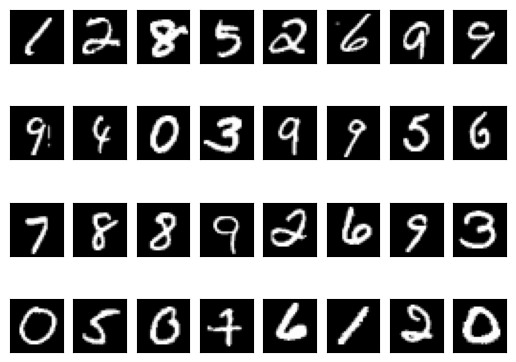

In [3]:
samples, labels = next(iter(train_loader))

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## **4. Define our Discriminator Model**

Our Descriminator receives the 28x28 image generated by our Generator and outputs a probability score of it belonging to the original dataset or not.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # We don't use Conv layers here but we vectorize our inputs
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

# We instantiate our mode and send it to the GPU
discriminator = Discriminator().to(device=device)

## **5. Define our Generator Model**

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        ### Generate random vector of length : 100
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # We use the Tanh() activation fucntion so that our outputs lie between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

# We instantiate our mode and send it to the GPU
generator = Generator().to(device=device)

## **Set our training parameters**

In [6]:
# Set our learning rate, epochs
lr = 0.0001
epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [7]:
for epoch in range(epochs):
    for n, (samples, labels) in enumerate(train_loader):
        # Get data for training the discriminator
        real_samples = samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Descrimianted Loss: {loss_discriminator}")
            print(f"Epoch: {epoch} Generator Loss: {loss_generator}")

Epoch: 0 Descrimianted Loss: 0.46926653385162354
Epoch: 0 Generator Loss: 0.7652083039283752
Epoch: 1 Descrimianted Loss: 0.010387642309069633
Epoch: 1 Generator Loss: 5.9539008140563965
Epoch: 2 Descrimianted Loss: 0.02071908488869667
Epoch: 2 Generator Loss: 6.380739688873291
Epoch: 3 Descrimianted Loss: 0.00972823891788721
Epoch: 3 Generator Loss: 5.387540817260742
Epoch: 4 Descrimianted Loss: 0.006419039331376553
Epoch: 4 Generator Loss: 6.332918167114258
Epoch: 5 Descrimianted Loss: 0.07016759365797043
Epoch: 5 Generator Loss: 4.673196315765381
Epoch: 6 Descrimianted Loss: 0.13033266365528107
Epoch: 6 Generator Loss: 3.752213954925537
Epoch: 7 Descrimianted Loss: 0.09281036257743835
Epoch: 7 Generator Loss: 4.176705837249756
Epoch: 8 Descrimianted Loss: 0.012045634910464287
Epoch: 8 Generator Loss: 6.442598819732666
Epoch: 9 Descrimianted Loss: 0.04137061536312103
Epoch: 9 Generator Loss: 5.393287658691406
Epoch: 10 Descrimianted Loss: 4.720021706816624e-08
Epoch: 10 Generator Los

## **5. Now let's Inspect our Generated Samples**

In [10]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

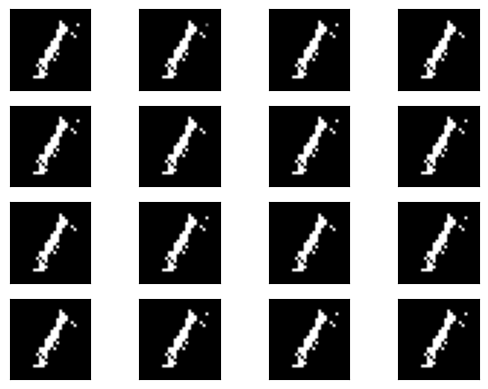

In [11]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])